# Procedure for estimating noise parameters

In [1]:
from __future__ import annotations

import numdifftools as nd
import numpy as np

from numpy.typing import ArrayLike
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
from scipy.optimize import approx_fprime
from numpy.random import default_rng

import thztools as thz
from thztools import tdnll

## Simulate measurements
Simulate a set of `m` waveforms, each sampled at `n` time points, with noise parameters
`sigma_alpha`, `sigma_beta`, and `sigma_tau`, and store them in an array `x`. Note that
`x` stores the waveforms in row orientation, with shape `(m, n)`, because NumPy
broadcasting rules and FFT functions are simpler for arrays that are row-oriented.
Measurement waveforms are typically loaded from data files in column orientation,
however, so the `tdnoisefit` function assumes that the data array is column-oriented—this
may be worth changing in a future version.

In [2]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
a = np.ones(m)
eta = np.zeros(m)

## Fit for the noise parameters

Set the initial guesses `a0` and `eta0` for the amplitudes and delays, respectively, and
estimate the noise parameters from the simulated measurements. Note that we must take the
transpose of `x`, to convert it from row-orientation to column-orientation.

In [3]:
result = thz.tdnoisefit(
    x.T, mu0=mu, a0=a, eta0=eta, ts=ts, fix_v=False, fix_mu=False, fix_a=False, fix_eta=False
)

KeyboardInterrupt: 

### Check the variance amplitude estimates

The `tdnoisefit` function returns a tuple with three elements: a dictionary `p` of output
parameters; the value `fval` of the cost function at those parameters; and a dictionary
`diagnostic` that includes additional diagnostic information about the result, including
the parameter uncertainty. Note that noise parameter uncertainty is expressed as a
standard deviation, so the uncertainty in the noise parameters refers to the standard
deviation of the variance amplitude. We apply the Poisson correction to each variance
parameter and its associated uncertainty—that is we multiply each by `m / (m - 1)`.

In [4]:
p_names = ["var_alpha", "var_beta", "var_tau"]
for i in range(3):
    val = result[0]['var'][i] * (m / (m - 1))
    err = result[2]['err']['var'][i] * (m / (m - 1))
    print(f"Estimated {p_names[i]}: {val:.4g} ± {err:.4g}")

Estimated var_alpha: 9.328e-11 ± 1.597e-12
Estimated var_beta: 7.837e-05 ± 3.294e-06
Estimated var_tau: 4.997e-06 ± 2.835e-07


In [5]:
cv = result[2]["cov"]

In [6]:
cv[:3, :3]

array([[ 2.93189032e-04, -4.16903477e-05,  8.70268944e-05],
       [-4.16904535e-05,  1.76632258e-03, -1.12169376e-03],
       [ 8.70269397e-05, -1.12169362e-03,  3.21744961e-03]])

In [7]:
result[2]["message"]

'Desired error not necessarily achieved due to precision loss.'

### Check the noise amplitude estimates

Compare the noise amplitude estimates with their true values, specified in the
simulation. The noise amplitudes are just the square root of the variance amplitudes,
and propagating the error for the noise amplitude uncertainty yields

$$
\sigma^2_{\sigma_k} = \left(\frac{dV_k}{d\sigma_k}\right)^{-2} \sigma^2_{V_k}
= \frac{1}{2\sigma_k} \sigma^2_{V_k}.
$$

In [8]:
p_names = ["sigma_alpha", "sigma_beta", "sigma_tau"]
for i in range(3):
    val = np.sqrt(result[0]['var'][i] * (m / (m - 1)))
    err = 0.5 * result[2]['err']['var'][i] * (m / (m - 1)) / val
    print(f"Estimated {p_names[i]}: {val:.4g} ± {err:.4g}")
for i in range(3):
    val = np.sqrt(result[0]['var'][i] * (m / (m - 1))) / sigma[i]
    err = (
        0.5
        * result[2]['err']['var'][i]
        * (m / (m - 1))
        / (sigma[i] ** 2)
    )
    print(
        f"Estimated {p_names[i]}, relative to true value: {val:.3f} ± {err:.3f}"
    )

Estimated sigma_alpha: 9.658e-06 ± 8.269e-08
Estimated sigma_beta: 0.008853 ± 0.000186
Estimated sigma_tau: 0.002235 ± 6.34e-05
Estimated sigma_alpha, relative to true value: 0.966 ± 0.008
Estimated sigma_beta, relative to true value: 0.885 ± 0.016
Estimated sigma_tau, relative to true value: 2.235 ± 0.142


Plot the data

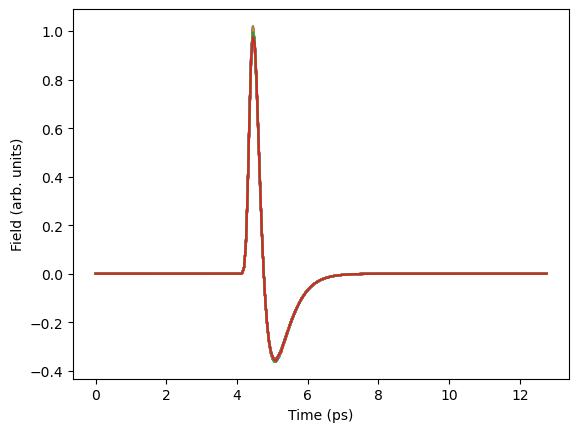

In [9]:
_, ax = plt.subplots()
ax.plot(t, x.T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

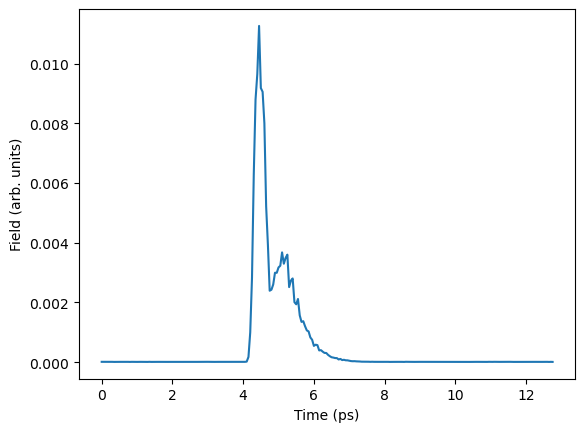

In [10]:
_, ax = plt.subplots()
ax.plot(t, np.std(x, axis=0).T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

## Consider alternative method
Try alternating between minimizing the least-squares portion of the cost function for fixed $\sigma$ and minimizing the log-likelihood as a function of $\sigma$ while holding all other parameters fixed.

## Check gradient calculation in tdnll

In [11]:
logv = np.log(sigma**2)
val, grad = tdnll(x, mu, logv, a, eta, ts, fix_logv=False, fix_mu=False, fix_a=False, fix_eta=False)

In [12]:
grad_logv = approx_fprime(logv, lambda _logv: tdnll(x, mu, _logv, a, eta, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0])
grad_mu = approx_fprime(mu, lambda _mu: tdnll(x, _mu, logv, a, eta, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0], epsilon=1e-10)
grad_a = approx_fprime(a, lambda _a: tdnll(x, mu, logv, _a, eta, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0])
grad_eta = approx_fprime(eta, lambda _eta: tdnll(x, mu, logv, a, _eta, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0])

In [13]:
grad_logv

array([ 3.82421875, 44.25585938, 15.07226562])

In [14]:
grad[:3]

array([ 3.82216259, 44.25424365, 15.07136749])

In [15]:
grad_mu

array([ 1.55712129e+06,  4.88694641e+05,  5.87318500e+05, -5.63966169e+05,
       -9.48453962e+05, -1.11420726e+06, -1.54134672e+06, -1.14151539e+06,
        2.91314791e+05, -3.42817220e+05,  8.32749065e+05, -5.84102818e+05,
       -1.09402579e+06, -5.36123698e+05, -1.79395574e+06, -1.65425881e+05,
        5.28019445e+05, -3.44309956e+04, -8.89845833e+05,  5.08642697e+05,
        5.56017621e+05, -8.85063200e+05, -1.38642587e+06,  2.99195235e+05,
       -1.41673052e+06,  2.08968937e+06,  1.40568591e+05,  1.05687650e+04,
       -6.32086594e+05, -3.35586374e+05,  6.09035487e+04, -7.67966849e+05,
        4.39799333e+05,  1.00700650e+06, -2.52009777e+05,  1.03100610e+05,
       -8.02603900e+05, -1.05232350e+06, -6.84169936e+05,  1.21251156e+06,
       -1.62818178e+05,  1.70740532e+05,  1.28511630e+06, -7.83592986e+05,
       -1.53946370e+06,  3.09998286e+05,  4.61778836e+04,  3.34702490e+05,
       -2.25414697e+05, -1.26242405e+06,  7.42840348e+04,  2.94009806e+04,
       -6.34020253e+05,  

In [16]:
grad[3: 3 + n]

array([ 1.55708929e+06,  4.88661781e+05,  5.87287566e+05, -5.63994582e+05,
       -9.48484397e+05, -1.11423785e+06, -1.54137805e+06, -1.14154956e+06,
        2.91283579e+05, -3.42848351e+05,  8.32715288e+05, -5.84136730e+05,
       -1.09405807e+06, -5.36153270e+05, -1.79398811e+06, -1.65456739e+05,
        5.27988257e+05, -3.44634231e+04, -8.89878954e+05,  5.08611553e+05,
        5.55984833e+05, -8.85097218e+05, -1.38645450e+06,  2.99163478e+05,
       -1.41676123e+06,  2.08965975e+06,  1.40533874e+05,  1.05374326e+04,
       -6.32116569e+05, -3.35616675e+05,  6.08722390e+04, -7.67999494e+05,
        4.39766211e+05,  1.00697518e+06, -2.52042934e+05,  1.03071190e+05,
       -8.02639104e+05, -1.05235645e+06, -6.84200619e+05,  1.21247978e+06,
       -1.62849938e+05,  1.70708903e+05,  1.28508579e+06, -7.83626421e+05,
       -1.53949515e+06,  3.09969803e+05,  4.61465713e+04,  3.34672875e+05,
       -2.25447519e+05, -1.26245213e+06,  7.42530653e+04,  2.93740196e+04,
       -6.34052581e+05,  

In [17]:
grad_a[1:]

array([-9.42343750e+01, -2.42988281e+01, -6.98003906e+02,  2.58910156e+02,
        3.39089844e+02, -6.72480469e+02, -5.10503906e+02,  1.00585938e+00,
       -4.93619141e+02, -1.64681641e+02, -2.00644531e+01,  7.97955078e+02,
        8.13257812e+02, -8.73494141e+02, -7.79478516e+02, -1.12865234e+02,
       -8.17982422e+02,  1.22718555e+03,  3.01375000e+02,  3.50937500e+01,
        8.07666016e+02, -7.82187500e+01,  4.63335938e+02,  6.05261719e+02,
       -1.93724609e+02, -3.28476562e+02, -6.92470703e+02, -1.47776953e+03,
        5.78228516e+02, -5.74980469e+02, -4.25761719e+01, -5.21212891e+02,
       -2.71466797e+02, -5.57587891e+02, -2.73962891e+02,  5.20103516e+02,
       -1.11443945e+03,  3.31089844e+02,  1.68931641e+02, -1.11230273e+03,
        4.03548828e+02, -1.01784570e+03,  6.20865234e+02, -5.40480469e+02,
        3.88572266e+02,  1.04422852e+03, -6.47187500e+01,  6.68408203e+02,
       -1.99818750e+03,  1.00313867e+03, -4.11144531e+02, -2.16044922e+02,
        2.02929688e+00,  

In [18]:
grad[3 + n : 3 + n + m - 1]

array([-9.42411625e+01, -2.42987324e+01, -6.98007268e+02,  2.58910884e+02,
        3.39084810e+02, -6.72484902e+02, -5.10512312e+02,  9.99283462e-01,
       -4.93632534e+02, -1.64694653e+02, -2.00682269e+01,  7.97951610e+02,
        8.13252644e+02, -8.73508921e+02, -7.79486708e+02, -1.12864082e+02,
       -8.17987326e+02,  1.22717685e+03,  3.01367422e+02,  3.50870932e+01,
        8.07665685e+02, -7.82232781e+01,  4.63333641e+02,  6.05252738e+02,
       -1.93734303e+02, -3.28478219e+02, -6.92479899e+02, -1.47777449e+03,
        5.78221240e+02, -5.74991921e+02, -4.25800971e+01, -5.21217776e+02,
       -2.71469463e+02, -5.57595312e+02, -2.73966078e+02,  5.20100123e+02,
       -1.11444918e+03,  3.31083723e+02,  1.68926104e+02, -1.11231077e+03,
        4.03544331e+02, -1.01785313e+03,  6.20862705e+02, -5.40485049e+02,
        3.88564957e+02,  1.04423015e+03, -6.47193232e+01,  6.68408692e+02,
       -1.99819973e+03,  1.00313307e+03, -4.11144583e+02, -2.16049643e+02,
        2.02294732e+00,  

In [19]:
grad_eta[1:]

array([ -2600.8203125 ,  -4574.46289062,    819.54882812,   4198.61914062,
         3028.13671875,  -2870.78125   ,  -2447.49023438,   1359.64648438,
         -988.640625  ,  -4397.82421875,   2401.26953125,   2409.60351562,
        -4369.82226562,    933.27929688,  -8203.72265625,  -5164.45703125,
         -568.98046875,    664.58007812,   5960.75195312,    -53.1328125 ,
        -2697.72851562,   3346.609375  ,   1029.71484375,  -1367.77539062,
          435.88476562,  -4920.046875  ,  -4538.79492188,   3846.45703125,
         -887.88867188,   2875.1875    ,  -3431.0390625 , -11381.09765625,
        -2465.27929688,  -4392.08398438,  -1001.6953125 ,   6866.16992188,
        -7469.53125   ,  -7577.296875  ,  -2523.13476562,   -203.94335938,
        -3297.75976562,  -5050.44335938,  -2064.25195312,  -5564.69335938,
          -56.34375   ,   2182.98046875,   2019.43554688,   3484.14453125,
        -4904.15429688,    995.57617188,  -1928.515625  ,   2078.42578125,
        -1586.90234375,  

In [20]:
grad[3 + n + m - 1 : 3 + n + 2 * (m - 1)]

array([ -2600.90881238,  -4574.5530577 ,    819.45728673,   4198.53240948,
         3028.04862766,  -2870.86785803,  -2447.58072351,   1359.56011826,
         -988.73406191,  -4397.91649023,   2401.17992395,   2409.51234808,
        -4369.91161947,    933.18418585,  -8203.81276936,  -5164.54337372,
         -569.06931224,    664.48911582,   5960.66157188,    -53.21556403,
        -2697.81606301,   3346.52275734,   1029.62734405,  -1367.86774791,
          435.79836324,  -4920.13161134,  -4538.88473875,   3846.36492086,
         -887.97608662,   2875.0884863 ,  -3431.12656801, -11381.1836537 ,
        -2465.36782999,  -4392.17445335,  -1001.78482203,   6866.08296055,
        -7469.62143067,  -7577.3821292 ,  -2523.21786566,   -204.03476414,
        -3297.84875234,  -5050.53242251,  -2064.33696268,  -5564.77824509,
          -56.43074698,   2182.89461999,   2019.35056685,   3484.05692934,
        -4904.24259592,    995.48606814,  -1928.60559554,   2078.33468326,
        -1586.98753262,  

In [31]:
def tdnll_logv(_logv): return tdnll(x, mu, _logv, a, eta, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0]

In [32]:
grad_logv_nd = nd.Gradient(tdnll_logv)(logv)

In [33]:
grad_logv_nd

array([ 3.82216259, 44.25424365, 15.07136749])

In [34]:
grad[:3]

array([ 3.82216259, 44.25424365, 15.07136749])

In [35]:
hess_logv_nd = nd.Hessian(tdnll_logv)(logv)

In [36]:
hess_logv_nd

array([[5887.59985164,   93.94490484,   14.79375904],
       [  93.94490484, 1526.81807146,  143.87422014],
       [  14.79375904,  143.87422014,  209.20853514]])

In [37]:
def tdnll_mu(_mu): return tdnll(x, _mu, logv, a, eta, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0]

In [95]:
grad_mu_nd = nd.Gradient(tdnll_mu, full_output=True)(mu)

In [96]:
grad_mu_nd

(array([ 1.55708769e+06,  4.88661338e+05,  5.87286933e+05, -5.63993970e+05,
        -9.48483497e+05, -1.11423668e+06, -1.54137656e+06, -1.14154836e+06,
         2.91283233e+05, -3.42847953e+05,  8.32714399e+05, -5.84136087e+05,
        -1.09405703e+06, -5.36152673e+05, -1.79398638e+06, -1.65456510e+05,
         5.27987663e+05, -3.44633211e+04, -8.89878133e+05,  5.08611115e+05,
         5.55984205e+05, -8.85096259e+05, -1.38645319e+06,  2.99163257e+05,
        -1.41675990e+06,  2.08965775e+06,  1.40533649e+05,  1.05375079e+04,
        -6.32116025e+05, -3.35616249e+05,  6.08720855e+04, -7.67998632e+05,
         4.39765674e+05,  1.00697428e+06, -2.52042784e+05,  1.03071192e+05,
        -8.02638409e+05, -1.05235529e+06, -6.84200048e+05,  1.21247869e+06,
        -1.62849895e+05,  1.70708856e+05,  1.28508437e+06, -7.83625507e+05,
        -1.53949374e+06,  3.09969631e+05,  4.61463820e+04,  3.34672688e+05,
        -2.25447446e+05, -1.26245071e+06,  7.42528287e+04,  2.93741583e+04,
        -6.3

In [60]:
grad[3 : 3 + n]

array([ 1.55708929e+06,  4.88661781e+05,  5.87287566e+05, -5.63994582e+05,
       -9.48484397e+05, -1.11423785e+06, -1.54137805e+06, -1.14154956e+06,
        2.91283579e+05, -3.42848351e+05,  8.32715288e+05, -5.84136730e+05,
       -1.09405807e+06, -5.36153270e+05, -1.79398811e+06, -1.65456739e+05,
        5.27988257e+05, -3.44634231e+04, -8.89878954e+05,  5.08611553e+05,
        5.55984833e+05, -8.85097218e+05, -1.38645450e+06,  2.99163478e+05,
       -1.41676123e+06,  2.08965975e+06,  1.40533874e+05,  1.05374326e+04,
       -6.32116569e+05, -3.35616675e+05,  6.08722390e+04, -7.67999494e+05,
        4.39766211e+05,  1.00697518e+06, -2.52042934e+05,  1.03071190e+05,
       -8.02639104e+05, -1.05235645e+06, -6.84200619e+05,  1.21247978e+06,
       -1.62849938e+05,  1.70708903e+05,  1.28508579e+06, -7.83626421e+05,
       -1.53949515e+06,  3.09969803e+05,  4.61465713e+04,  3.34672875e+05,
       -2.25447519e+05, -1.26245213e+06,  7.42530653e+04,  2.93740196e+04,
       -6.34052581e+05,  